# 15 - 合成控制法

## 揭示不可知之物的数学技巧

当我们研究双重差分法时，我们掌握了来自两个不同城市——POA和FL——多位客户的数据。这些数据跨越了两个时间段：在阿雷格里港实施营销干预以提升客户存款之前和之后。为了估计处理效应，我们进行了回归分析，得出了双重差分估计量及其标准误。

在那个案例中，由于数据是细分的，我们拥有大量样本。但如果我们手头只有城市层面的汇总数据呢？例如，假设我们仅掌握干预前后两个城市的平均存款水平。

|city|before|after|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

我们仍能够计算双重差分估计量

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$

然而，需要注意的是，此处的样本量仅为 4，而这恰好也是我们双重差分模型中的参数数量。在这种情况下，标准误差的定义并不明确，那么我们该如何应对？另一个问题是，FL可能与我们所期望的与POA的相似度有所差距。例如，FL以其美丽的海滩和悠闲的居民而闻名，而POA则更因其烧烤文化和草原风光著称。这里的核心难题在于，我们永远无法完全确定所采用的控制组是否恰当。

为解决这一问题，我们将采用被誉为[**"过去几年政策评估文献中最重要创新"**](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3)的合成控制法（Synthetic Control）。 它基于一个简单却强大的思想：我们不需要在未处理单元中找到一个与处理单元极为相似的单一单位。相反，可以通过组合多个未处理单元来构建一个虚拟的合成控制单元。合成控制法因其卓越效果与直观逻辑，甚至得以在非学术期刊[《华盛顿邮报》](https://www.washingtonpost.com/news/wonk/wp/2015/10/30/how-to-measure-things-in-a-world-of-competing-claims/)上发表专题文章。

In [78]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

为了展示合成控制法的实际应用，我们来看一个经典问题：评估香烟税收对香烟消费的影响。

这个问题在经济学界争论已久。一方认为，提高香烟税会增加购买成本，从而抑制需求；另一方则指出，香烟具有成瘾性，即使价格上涨，需求也不会显著减少。用经济学术语说，后者认为香烟的价格弹性很低，加税只是政府增加财政收入的一种手段，其代价是由吸烟者承担。

为了弄清楚这个问题，我们将分析一组关于美国香烟消费的历史数据。

1988 年，加利福尼亚州通过了一项著名的《烟草税与健康保护法案》，也被称为 [Proposition 99](https://en.wikipedia.org/wiki/1988_California_Proposition_99)（第 99 号提案）。其主要内容是：对每包香烟征收 25 美分的州消费税，同时对雪茄、嚼烟等其他烟草产品的零售销售也施加了大致相当的税负。此外，法案还规定了多项限制措施，包括：禁止在青少年可进入的公共区域内设置香烟自动售货机；禁止单支香烟的零售销售。该法案所产生的税收专门用于多个环保和医疗项目，并资助反烟草广告活动。

为评估其效果，我们可以收集多个州多年间的香烟销售数据。在本案例中，我们获取了 1970 年至 2000 年间来自 39 个州的数据。其余那些在同期推行了类似烟草控制政策的州则被排除在分析之外。以下是我们的数据概况：

In [80]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


我们以 `state` 作为州索引，其中加利福尼亚州编号为 3。我们的协变量包括 `retprice` （香烟零售价格）和 `cigsale` （人均香烟销售量，以包计）。我们关注的结果变量是 `cigsale` 。最后，我们还设置了两个布尔变量作为辅助来标识加利福尼亚州及干预后时期。若绘制各州随时间变化的香烟销售情况，将得到如下图表。

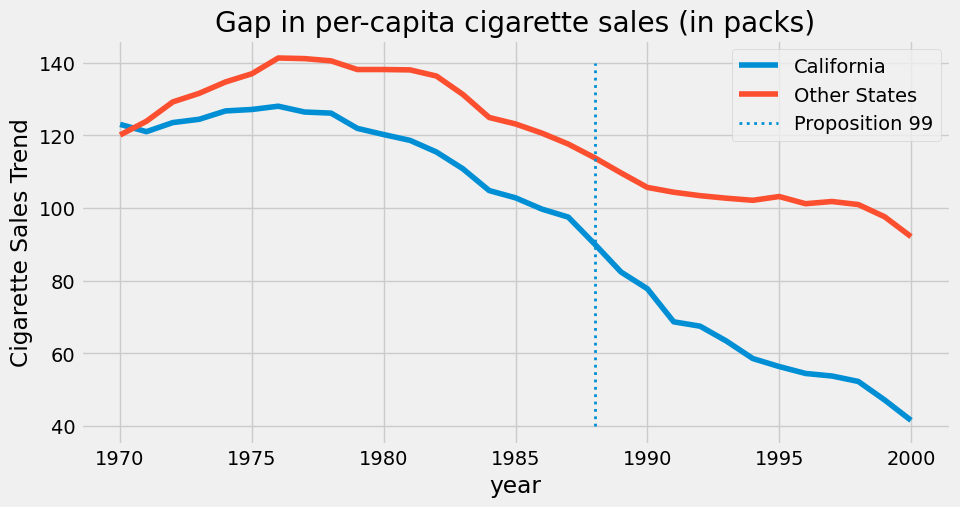

In [191]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot(index="year", columns="california", values="cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend()
plt.show();  

在现有数据覆盖的时间段内，加利福尼亚州的香烟购买量明显低于全国平均水平。此外，80 年代后香烟消费似乎呈现下降趋势。从图表观察推测，相比其他州，99 号提案通过后加利福尼亚州的下降趋势有所加速，但这一结论尚不确定，仅为基于图表观察的初步推断。

为了回答第 99 号提案是否对香烟消费产生影响的问题，我们将利用干预前的时期构建一个合成对照组。我们将**通过组合其他州来创建一个模拟州，其趋势与加利福尼亚州高度相似**。随后，我们将观察这一合成对照组在干预后的表现。

## 数据不够？让时间补上

为了使表述更为正式，假设我们拥有 $J+1$ 个单位，在不失一般性的情况下，设单位 1 为受干预影响的单位。单位 $j=2,...,J+1$ 构成一组未经处理的单位，我们称之为“控制组（donor pool）”。同时假设数据覆盖 T 个时间段，其中 $T_0$ 个为干预前的时期。对于每个单位 j 和每个时间点 t，我们观测到结果 $Y_{jt}$。对于每个单位 j 和时期 t，定义 $Y^N_{jt}$ 为无干预时的潜在结果，$Y^I_{jt}$ 为有干预时的潜在结果。那么，在时间 t（$t>T_0$）对受处理单位 $j=1$ 的效应定义为：

$
\tau_{1t} = Y^I_{1t} - Y^N_{1t}
$

由于单位 $j=1$ 是接受处理的那个， $Y^I_{1t}$ 是事实性的，但 $Y^N_{1t}$ 则不是。接下来的挑战在于如何估计 $Y^N_{1t}$。注意到处理效应是随时间定义的，这意味着它可以随时间变化，不必是即时的，可以累积或消散。形象地说，估计处理效应的问题归根结底是**估计单位 $j=1$ 如果未被处理，其结果将会如何的问题**。

![img](images/15/synth_img.png)

为了估计 $Y^N_{1t}$，我们记得控制组中单位的组合可能比任何单独未处理单位更能近似处理单位的特征。因此，合成控制被定义为控制组中单位的加权平均。给定权重 $\pmb{W}=(w_2, ..., w_{J+1})$ ，$Y^N_{1t}$ 的合成控制估计值为

$
\hat{Y}^N_{1t} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

如果这些数学让你头疼，你并不孤单。但别担心，我们有很多例子可以让它更直观。这一次，我喜欢将合成控制视为回归的一种逆向思维方式。众所周知，线性回归也是通过变量的加权平均来获得预测的一种方法。现在，想想那些回归，就像在双重差分法例子中那样，每个变量都是一个时间段的虚拟变量。在这种情况下，回归可以表示为以下矩阵乘法：

![img](images/15/regr_time.png)

在合成控制的情形下，我们不是拥有很多单位（个体），而是拥有很多时间点。因此，我们的做法是将输入矩阵“翻转”过来。这样一来，各个“单位”就成了回归中的“变量”，而结果变量则表示为这些单位的加权平均，如下面的矩阵乘法所示：

![img](images/15/regr_space.png)

如果每个时间点有多个特征变量，我们可以像这样把这些特征堆叠起来。关键在于，使这个“回归”过程尝试用其他单位的数据来“预测”第 1 个被处理单位，从而以某种最优方式选择权重以达到所需的近似效果。我们甚至可以对特征进行不同比例的缩放，以赋予它们不同的重要性。

![img](images/15/regr_space_x.png)

那么，既然合成控制法可视为线性回归，是否意味着我们也能用普通最小二乘法（OLS）估计其权重呢？没错！实际上，我们现在就来实践这一点。


## 将合成控制法视作线性回归

![img](images/15/allways.png)

为用合成控制法估计处理效应，我们将尝试构建一个在干预前与处理单元相似的“虚拟单元”，然后观察该“虚拟单元”在干预后的表现。合成控制与其模拟单元之间的差异即为处理效应。

为此，我们将使用普通最小二乘法（OLS）确定权重，并最小化干预前时期控制组中单元加权平均值与处理单元之间的平方距离。

为此，首先需要将单元（本案例中指各州）转换为列，时间转换为行。由于我们有两个特征变量 `cigsale` 和 `retprice` ，我们将如上图所示将它们垂直堆叠。我们将构建一个在干预前时期与加利福尼亚州高度相似的合成控制组，观察其在干预后时期的表现。因此，仅选择干预前时期数据至关重要。此处各特征量纲相近，故无需处理。若特征量纲差异显著（如一个为千位数级，另一个为小数级），较大特征在差异最小化过程中将占据主导地位。为避免此问题，需先进行特征缩放。

In [85]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

现在，我们可以将加利福尼亚州定义为 Y 变量，其他州定义为 X 变量。

In [88]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

接着，我们进行回归分析。包含截距项相当于添加了一个所有行值均为 1 的额外状态。虽然可以这样做，但我觉得这样会使问题复杂化，因此决定省略这一步骤。回归分析将返回一组权重，这些权重能最小化处理单元与供体池中单元之间的平方差异。

In [91]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

这些权重向我们展示了如何构建合成控制组。我们将州 1 的结果乘以-0.436，州 2 的结果乘以-1.038，州 4 的结果乘以 0.679，以此类推。通过供体池中各州构成的矩阵与权重点积运算，即可实现这一目标。

In [94]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

现在我们已经得到了合成控制组，可以将其与加利福尼亚州的结果变量一同绘制成图。

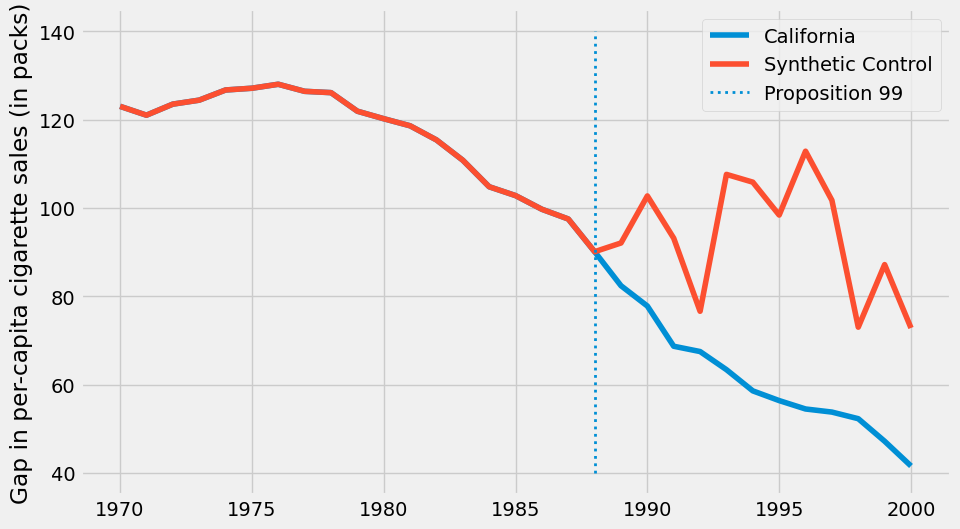

In [179]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend()
plt.show();

好的…似乎有些不对劲。这张图中首先吸引你注意的是什么？首先，干预后，合成控制组的香烟销量超过了加利福尼亚州。这表明干预措施在降低香烟需求方面是成功的。其次，注意到干预前期的拟合效果近乎完美。合成控制组能够精确匹配加利福尼亚州的数据。这预示着我们的合成控制模型可能存在对数据的过度拟合。另一个迹象是干预后合成控制组结果变量的巨大波动。观察其走势并非平稳，而是呈现出上下起伏的波动模式。

![img](images/15/out-of-sample.png)

若我们思考为何会出现这种情况，需记得我们的控制组中有 38 个州。因此，线性回归模型拥有 38 个参数可供调整，以期预处理池尽可能匹配处理组。此情形下，即便时间维度 T 较大，样本量 N 同样庞大，这赋予了线性回归模型过高的灵活性。若您熟悉正则化模型，可知可采用[岭回归](https://zh.wikipedia.org/wiki/岭回归)或 [Lasso回归](https://zh.wikipedia.org/wiki/Lasso算法)来修正此问题。此处，我们将探讨另一种更为传统的方法以避免过拟合。

## 切勿超出数据支持的范围

假设您拥有如下表所示的数据，并被要求构建一个合成控制组，通过控制单元的任何线性组合来复现处理单元。

|unit|sales|price|
|--|--|--|
|control 1|8|8|
|control 2|8|4|
|control 3|4|5|
|treated  |2|10|

由于存在 3 个单元但仅需匹配 2 个属性，此问题存在多种精确解，但一种巧妙的解法是将第一个对照组乘以 2.25，第二个乘以-2 后相加。注意第二个乘法操作会生成一个销售为-16、价格为-8 的虚拟单元。这种乘法运算将对照组 2 单元外推至数据中不太合理的区域，因为负价格和负销售额几乎不可能存在。第一个乘法同样属于外推，它将首个单元带至销售额和价格均为 18 的区域。这些数值远高于我们数据中的任何记录，因此构成了外推。

这就是当我们要求回归分析创建合成控制组时其背后的运作机制。从技术上讲外推并无错误，但在实践中具有风险。我们实际上是在假设未见数据的行为模式与现有数据相同。

一种更安全的做法是将合成控制限制为仅进行插值。为此，我们将约束权重为正且总和为一。此时，合成控制将成为供体池中单元的凸组合。在进行插值时，我们会将处理单元投影到由未处理单元定义的凸包内，如下图所示。

![img](images/15/extrapolation.png)

这里需要注意两点。首先，在此情况下，插值无法完美匹配处理单元。这是因为该处理单元具有最低的销售量和最高的价格。凸组合只能精确复制处于控制单元之间的特征。另一点值得注意的是插值具有稀疏性。我们会将处理单元投影到凸包的某个面上，而这个面仅由少数几个单元定义。因此，插值会给许多单元分配零权重。

这是基本思路，现在让我们稍作形式化。合成控制仍定义为 

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

但现在，我们将使用最小化以下表达式的权重 $\pmb{W}=(w_2, ..., w_{J+1})$ 

$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}
$

受限于 $w_2, ..., w_{J+1}$ 为正且总和为一的限制条件。注意，$v_h$ 反映了在最小化处理组与合成控制组差异时各变量的重要性。不同的 $v$ 会得出不同的最优权重。选择 $V$ 的一种方法是使每个变量均值为零且具有单位方差。更复杂的方式是根据变量对预测 $Y$ 能力的贡献赋予其相应的重要性。为保持代码简洁，我们将统一赋予各变量相同的重要性。

为实现此目标，首先需定义上述损失函数。

In [100]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

由于我们对所有特征采用相同的重要性权重，因此无需考虑 $v$。

现在，为获取最优权重，我们将利用 scipy 的二次规划优化方法，并通过约束条件确保权重总和为 1。

```python 
lambda x: np.sum(x) - 1
```

此外，我们将优化边界设定在 0 到 1 之间。

In [103]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

实现这一点后，我们将获取定义合成控制的权重。

In [106]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.0000000000007276


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

利用这一权重，我们将状态 1、2 和 3 乘以零，状态 4 乘以 0.0852，以此类推。注意到权重是稀疏的，正如我们预测的那样。此外，所有权重之和为一且介于 0 与 1 之间，满足我们的凸组合约束条件。

现在，要得到合成控制，我们可以像之前处理回归权重那样，用这些权重乘以各状态。

In [109]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

若现在绘制合成控制法的结果，我们会得到一条更为平滑的趋势线。同时注意到，在干预前的时期，合成控制组不再精确复制处理组的表现。这是一个积极的信号，表明我们没有过度拟合。

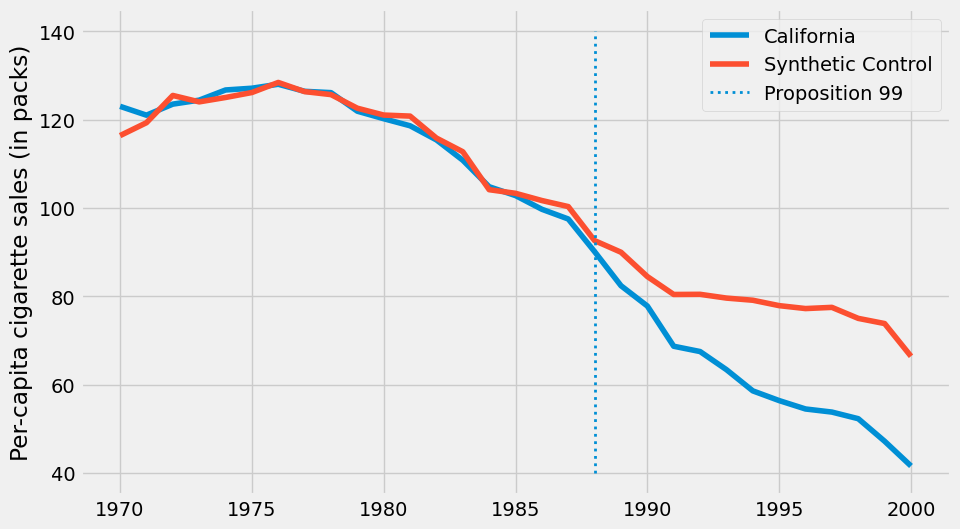

In [181]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend()
plt.show();

有了合成控制法后，我们可以通过处理组与合成控制组结果之间的差距来估计处理效应。

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

在本案例中，随着时间的推移，效应呈现出逐渐扩大的趋势。

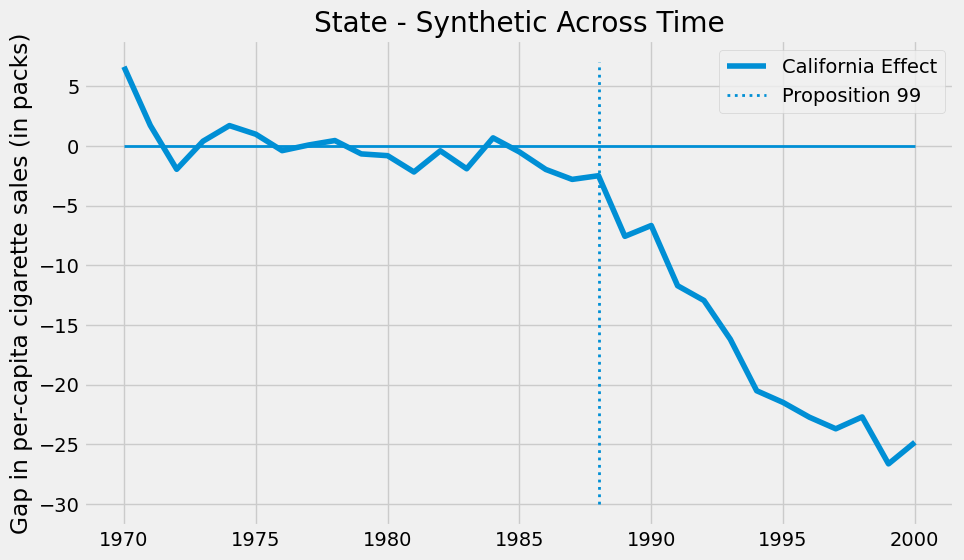

In [183]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend()
plt.show();

截至 2000 年，第 99 号提案似乎使香烟销量减少了约 25 包。这一发现固然令人振奋，但你可能不禁要问：如何判断这一结果是否具有统计学显著性？

## 做出可信推论

由于我们的样本量非常小（39 个），在判断结果是否具有统计显著性而非仅由随机运气所致时，我们需要更加机智。这里，我们将运用[费希尔精确检验](https://zh.wikipedia.org/wiki/費雪正確概率檢定)的思想。其原理十分直观：我们穷尽所有可能对处理组和对照组进行排列组合。鉴于我们仅有一个处理单元，这意味着针对每个单元，我们假设其为处理组，而其他单元则作为对照组。

|iteration（迭代）|1|2|...|39|
|----|-|-|-|-|
|1|treated|0|0|0|
|2|0|treated|0|0|
|...|0|0|0|0|0|0|
|39|0|0|0|treated|

最终，我们将为每个州得到一个合成控制组及效应估计值。这一方法的原理是假设另一个非加利福尼亚州实际接受了处理，观察这一未真实发生的处理可能产生的估计效应。随后，我们将加利福尼亚州的处理效应与这些虚构处理效应进行比较，检验其是否显著更大。核心思想在于，对于那些实际未受处理的州，一旦我们假设它们接受了处理，应当无法检测到任何显著的处理效应。

为实现这一目标，我构建了一个函数，该函数以州名作为输入，计算该州的合成控制组。此函数返回一个数据框，包含州名、年份、实际结果 `cigsale` 以及该州合成结果四列数据。

In [118]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

这是我们将其应用于初始状态时得到的结果。

In [121]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


为获取所有状态的结果，我们通过 8 个进程并行计算。若您的计算机核心数不同，可调整此数值。此代码将返回如上所示的一系列数据框。

In [124]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [125]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


通过为所有州构建合成控制组，我们能够估算各州合成数据与真实状态之间的差距。对加利福尼亚州而言，这一差距即处理效应；而对其他州来说，这类似于安慰剂效应——我们估算的是实际上并未实施处理的合成控制处理效应。若将所有安慰剂效应与加州处理效应绘制于同一图表，则得到下图所示结果。

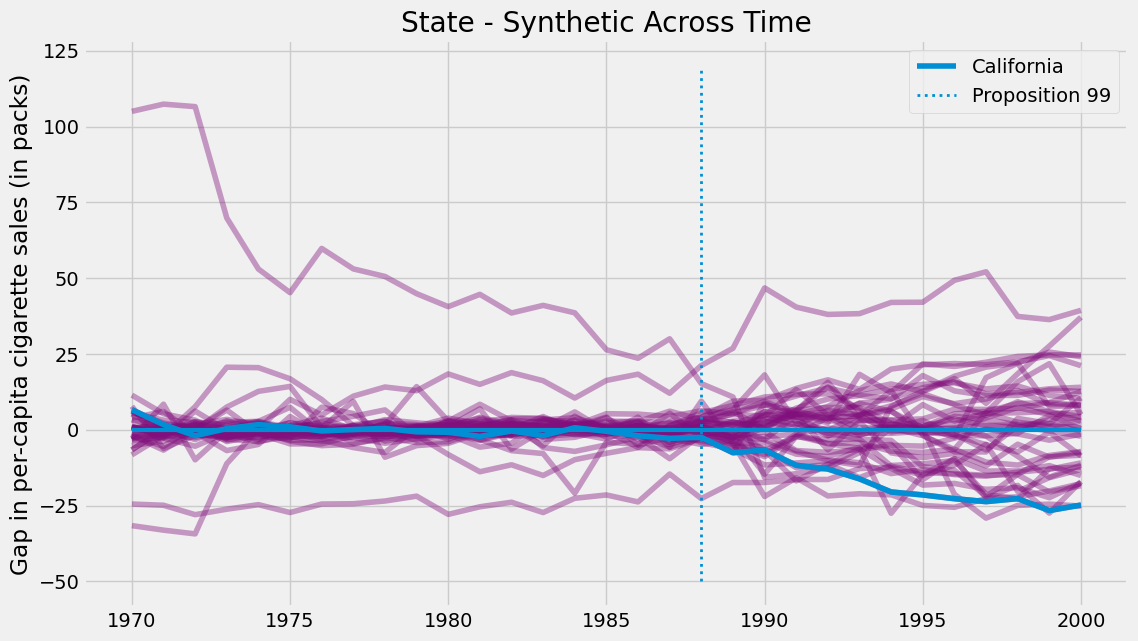

In [185]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend()
plt.show();

该图表呈现两个显著特征。首先可见干预后的方差明显大于干预前，这符合预期，因为合成控制法的设计初衷正是最小化干预前时期的差异。另一有趣现象是，即便在干预前阶段，某些单元仍难以实现良好拟合。这同样可以预见，例如某些州卷烟消费量极高，其他州的任何凸组合都无法与之匹配。

鉴于这些单元的拟合效果极差，将其从分析中剔除是明智之举。客观的做法之一是为干预前误差设定阈值作为筛选标准。

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

并剔除误差较大的单元。若按此步骤操作并绘制相同图表，我们将得到如下结果。

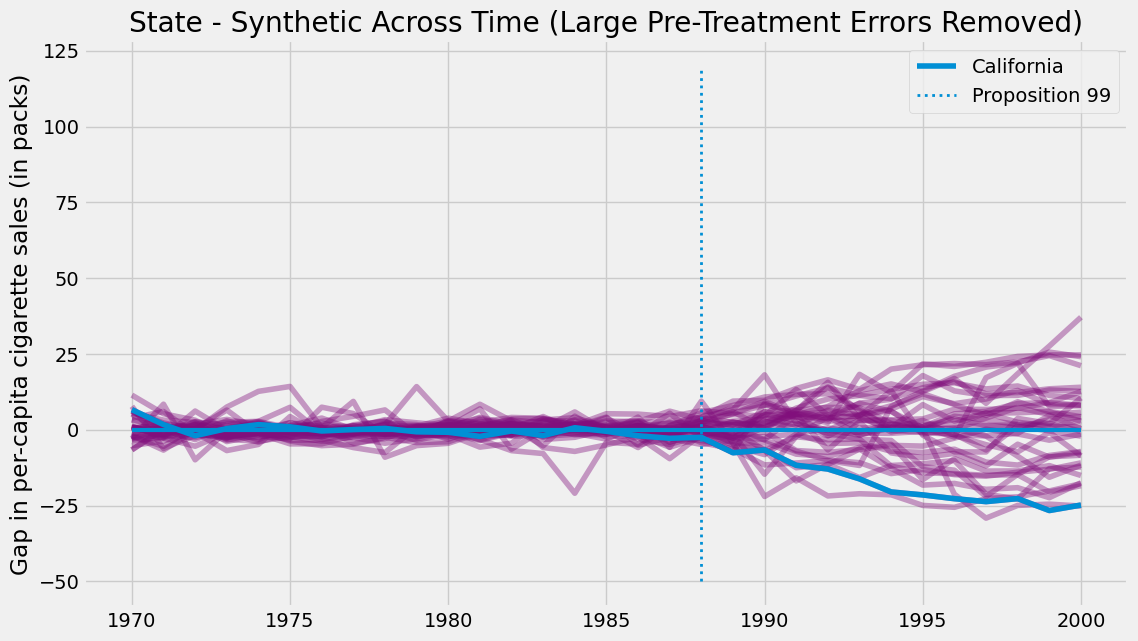

In [187]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend()
plt.show();

消除噪声后，我们可以看出加利福尼亚州的效应值有多么极端。此图像表明，若假设处理发生在其他任何州，我们几乎不可能获得像加州那样极端的效应。

仅此图像本身即是一种推断形式，但我们还能从这些结果中推导出 P 值。只需统计我们得到的效应低于加州效应的次数即可。

In [134]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015973934797


array([  5.79715892,   0.89458999, -24.83015974,  -7.16628121,
       -10.92204857,  37.11640559, -15.0697171 ,  -0.49805149,
       -18.45795098,  21.1336645 ,  12.57782779,  -1.47547826,
        10.4962737 , -11.67012358,   4.29850815,   8.0481141 ,
        14.02322419,   8.25002714,   0.32576354,  -8.40826871,
        -2.12402704,  -7.42865045,   2.96157488,  24.10478105,
         4.2521177 , -17.75844573,   7.93334017,   2.81640134,
        12.6495596 , -17.47677514, -25.16040945, -12.26469129,
        24.69067373,  10.36299588,  -8.59880385])

若要检验"加州效应低于零"的单侧假设，我们可以将 P 值估计为加州效应大于所有估计效应的比例。

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}
$

结果表明，2000 年加利福尼亚州的处理效应为-24.8，意味着干预措施使得香烟消费量减少了近 25 包。在我们估算的所有其他 34 个安慰剂效应中，仅有一个高于在加利福尼亚州发现的效果。因此，p 值为 1/35。

In [138]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857

最后，我们可以展示效应分布，以便直观了解加利福尼亚州效应值的极端程度。 

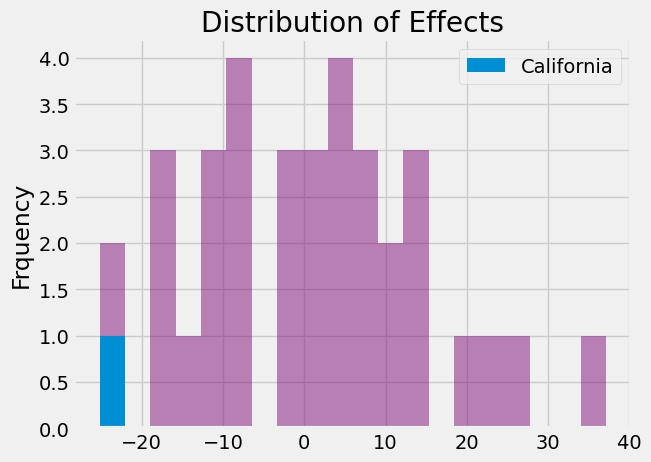

In [189]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend()
plt.show();

## 核心要点

我们了解到，如果仅拥有城市或州等实体的聚合层面数据，双重差分法将无法进行推断。此外，该方法还存在其他局限性，因为它需要定义一个对照单元，而单一对照单元可能不足以很好地代表处理单元的反事实情况。

为纠正这一问题，我们学会了构建一个综合对照组（控制组），通过组合多个对照单元使其更接近处理单元的特征。借助这一合成控制方法，我们得以观察在没有干预的情况下，处理单元可能发生的变化。

最后，我们探讨了如何利用费希尔精确检验（Fisher’s Exact Tests）进行合成控制的推断。具体而言，我们假设未受干预的单元实际上接受了处理，并计算了其效应。这些即为安慰剂效应：即使在没有干预的情况下也能观察到的效应。我们借此评估所估计的处理效应是否具有统计学显著性。




## 致谢
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 贡献
《因果推断：献给求真敢为者》是一份关于因果推断的开源材料，属于科学统计领域。它仅基于 Python 使用免费软件，旨在实现经济与智力上的双重可及性。若您认为此书有价值并希望支持，请前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)。若暂无法经济支持，您也可以通过修正拼写错误、建议修改或对不理解的内容提供反馈来帮助改进。只需访问书籍仓库并提交问题。最后，若您喜欢此内容，请分享给可能受益的人，并在 GitHub 上为其加星。